# Learning a GNN potential for diamond

In this notebook, we will learn a graph neural network (GNN) potential from experimental stiffness tensor data.
We will directly apply the DiffTRe library. If you are interested in the working mechanisms of DiffTRe, please have a look at
the double well notebook.

We will define all components necessary to initialize DiffTRe: experimental data, simulation box, GNN potential with prior, simulator, loss function and optimizer.


In [1]:
from DiffTRe import io, custom_space, custom_energy, custom_quantity, difftre, custom_simulator
from jax_md import partition, simulate, space
import optax
from jax import jit, random, device_get, checkpoint, tree_util
import jax.numpy as jnp
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import time, pickle
import warnings
warnings.filterwarnings('ignore')  # disable warnings about float64 usage

energy_pickle_file_path = 'output/saved_models/Diamond_GNN.pkl'
optimization_pickle_file_path = 'output/saved_optimization_results/Diamond_optimization.pkl'
long_traj_pickle_file_path = 'output/saved_optimization_results/Diamond_long_traj.pkl'

### Experimental observables

It is often useful to start with the experimental target data. In this example, these are elastic stiffness tensor values from an
experiment conducted in the paper _The Elastic Stiffness Moduli of Diamond_ [(McSkimin et. al., 1972)](https://doi.org/10.1063/1.1661318).
Due to symmetries in cubic crystals, the stiffness tensor consists of three distinct stiffness moduli $c_{11}$,
$c_{12}$ and $c_{44}$ (in Voigt notation).</br>
In the un-strained state, we assume the crystal to be in a stress-free state.
The second target observable is therefore an initial stress tensor of $\mathbf{0}$.

In [2]:
c_11_target = 1079.  # in GPa
c_12_target = 124.
c_44_target = 578.

convert_from_GPa_to_kJ_mol_nm_3 = 10**3 / 1.66054
stiffness_targets = jnp.array([c_11_target, c_12_target, c_44_target]) * convert_from_GPa_to_kJ_mol_nm_3

target_dict = {'stress': jnp.zeros((3, 3)), 'stiffness': stiffness_targets}

### Simulation setup

Next, we need to define the parameters of the simulation.
Some of these parameters are already defined by the experiment, e.g. temperature and density of the material during
the experiment.

In [3]:
system_temperature = 298.15  # Kelvin = 25 deg. celsius
Boltzmann_constant = 0.0083145107  # in kJ / mol K
kbT = system_temperature * Boltzmann_constant

experimental_density = 3512  # kg / m^3
mass = 12.011  # mass of carbon atoms in u

file_loc = 'data/confs/Diamond.pdb'
R_init, _, box = io.load_configuration(file_loc)  # initial configuration of a diamond crystal
N = R_init.shape[0]
density = mass * N * 1.66054 / jnp.prod(box)
box *= (density / experimental_density) ** (1 / 3)  # adjust box size to experiment
density = mass * N * 1.66054 / jnp.prod(box)
print('Model Density:', density, 'kg/m^3. Experimental density:', experimental_density, 'kg/m^3')

# simulation times in ps
dt = 0.5e-3
total_time = 70.
t_equilib = 10.  # discard all states within the first 5 ps as equilibration
print_every = 0.025  # save states every 0.1 ps for use in averaging
timing_struct = custom_simulator.process_printouts(dt, total_time, t_equilib, print_every)

# we need to take derivatives wrt. the simulation box to compute the stiffness tensor
# we therefore use a differentiable box in fractal coordinates: all atom positions are mapped onto a unit cube
R_init, box_tensor = custom_space.scale_to_fractional_coordinates(R_init, box)
displacement, shift = space.periodic_general(box_tensor)

Model Density: 3511.9998 kg/m^3. Experimental density: 3512 kg/m^3


### GNN Potential

Now we define the GNN as well as the prior potential functioning as an advantageous
starting point for the optimization. As prior potential, we select the Stillinger-Weber potential originally developed
for silicon and only roughly adjust the length scale $\sigma$ and energy scale $\epsilon$ such that it is compatible
with diamond. After defining both potentials, we can combine them by simply adding computed
potential energy values. This is done inside the `energy_fn_template` defining a combined `energy` function from the
current GNN weights. This scheme enables updating GNN weights during the optimization without compromising
"jitability". You can define a custom template by creating a function that takes current learnable weights and returns a
corresponding `energy_fn`.

In [4]:
key = random.PRNGKey(0)  # define random seed for initialization of model and simulation
model_init_key, simuation_init_key = random.split(key, 2)

# prior parameters
sigma = 0.14  # nm
eps = 200  # kJ / mol
r_cut_SW = sigma * 1.8  # a = 1.8 in original SW potential
r_cut_NN = 0.2

# we use the same neighbor list for prior and GNN to avoid keeping track of 2 separate lists
r_cut_nbrs = max(r_cut_SW, r_cut_NN)
box_nbrs = jnp.ones(3)  # give hypercube box as we are using fractional coordinates
neighbor_fn = partition.neighbor_list(displacement, box_nbrs, r_cut_nbrs, dr_threshold=0.05, capacity_multiplier=1.5, 
                                     disable_cell_list=True)
nbrs_init = neighbor_fn(R_init)

init_fn, GNN_energy = custom_energy.DimeNetPP_neighborlist(displacement, R_init, nbrs_init, r_cut_NN)
init_params = init_fn(model_init_key, R_init, neighbor=nbrs_init)

prior_fn = custom_energy.stillinger_weber_neighborlist(displacement, cutoff=r_cut_SW, sigma=sigma, epsilon=eps,
                                                        initialize_neighbor_list=False)


def energy_fn_template(energy_params):
    gnn_energy = partial(GNN_energy, energy_params)
    def energy(R, neighbor, **dynamic_kwargs):
        return gnn_energy(R, neighbor=neighbor, **dynamic_kwargs) + prior_fn(R, neighbor=neighbor, **dynamic_kwargs)
    return jit(energy)

### Loss function
After defining the `energy_fn_template`, we can define the loss function. We compute the stiffness tensor
via the 'stress-fluctuation method', where multiple instantaneous quantities need to be combined:
$$C_{ijkl} = \langle C^B_{ijkl} \rangle - \frac{V}{k_B T}\left(\langle \sigma^B_{ij} \sigma^B_{kl} \rangle -
\langle \sigma^B_{ij} \rangle \langle \sigma^B_{kl} \rangle\right) + \frac{N k_B T}{V}\left( \delta_{ik} \delta_{jl} +
\delta_{il} \delta_{jk} \right)$$
$$\mathrm{with} \quad \sigma^B_{ij} = \frac{1}{V}\frac{\partial U}{\partial \epsilon_{ij}} \ ; \quad  C^B_{ijkl} =
\frac{1}{V}\frac{\partial^2 U}{\partial \epsilon_{ij} \partial \epsilon_{kl}}$$

We therefore need to compute instantaneous values of stresses $\sigma_{ij}$, $\sigma^B_{ij}$ and $C^B_{ijkl}$ and combine them to observables $\langle \sigma_{ij} \rangle$ and $C_{ijkl}$.
Therefore, we cannot use the default loss function in `DiffTRe_init` because it is only applicable to
observables that are directly computed as averages of instantaneous quantities.

We can compute instantaneous quantities from a trajectory via a `quantity_dict`. It requires for each instantaneous observable $O_k(S_i, U_{\theta})$ a function to compute the respective observable for each state $S_i$. 
In the end, we combine loss contributions from stress and stiffness tensors by multiplication of each component with a scale $\gamma$, which is useful to counteract the effect of different units / orders of magnitude of observables.

When constructing a custom loss function, we need to adhere to the function signature required by the implementation of DiffTRe:
`Loss_fn` takes as input the trajectory of computed instantaneous quantities saved in a dict under its respective key of the `quantitiy_dict`. Additionally, it receives corresponding weights $w_i$ to compute averages under the reweighting scheme. With these components, target observables can be computed.
The output of the function is a tuple `(loss value, predicted ensemble averages)`. The latter is only necessary
for post-processing of the optimization process. `loss_fn` below provides an example implementation.

In [5]:
# initialize observable functions
stress_fn = custom_quantity.init_virial_stress_tensor(energy_fn_template, box_tensor)

born_stiffness_fn, sigma_born, sigma_tensor_prod, stiffness_tensor_fn = \
    custom_quantity.init_stiffness_tensor_stress_fluctuation(energy_fn_template, box_tensor, kbT, N)

# add all functions that compute instantaneous values into quantity_dict
# DiffTRe computes correspondig quantities for each state in the (sparse) trajectory
# checkpoint is needed to avoid out-of-memory errors for expensive models, e.g.  GNNs
quantity_dict = {}
quantity_dict['stress'] = {'compute_fn': checkpoint(stress_fn)}
quantity_dict['born_stiffness'] = {'compute_fn': checkpoint(born_stiffness_fn)}
quantity_dict['born_stress'] = {'compute_fn': checkpoint(sigma_born)}

gamma_stress = 5.e-8
gamma_stiffness = 1.e-10

def loss_fn(quantity_trajs, weights):
    
    def reweighting_average(quantity_snapshots):
        weighted_snapshots = (quantity_snapshots.T * weights).T
        return jnp.sum(weighted_snapshots, axis=0)
    
    # compute all contributions to stiffness tensor
    born_stress_prod_snapshots = sigma_tensor_prod(quantity_trajs['born_stress'])
    stress_product_born_mean = reweighting_average(born_stress_prod_snapshots)  # <sigma^B_ij sigma^B_kl>
    born_stress_tensor_mean = reweighting_average(quantity_trajs['born_stress'])
    born_stiffness_mean = reweighting_average(quantity_trajs['born_stiffness'])
    stiffness_tensor = stiffness_tensor_fn(born_stiffness_mean, born_stress_tensor_mean, stress_product_born_mean)
    
    stiffness_pred = custom_quantity.stiffness_tensor_components_cubic_crystal(stiffness_tensor)
    stress_tensor_mean = reweighting_average(quantity_trajs['stress'])
    
    loss = gamma_stress * difftre.mse_loss(stress_tensor_mean, target_dict['stress']) + \
           gamma_stiffness * difftre.mse_loss(stiffness_pred, target_dict['stiffness'])
    
    
    predictions = {'stress': stress_tensor_mean, 'stiffness': stiffness_pred}
    
    return loss, predictions


### Simulator

Let's define a `simulator_template` taking the current potential energy function from the `energy_fn_template` as input
and returning a NVT simulator for the current energy function. This is achieved by simply "baking in" all constant
simulation parameters via `partial`. For this example, we select a Langevin thermostat.
With a given simulator, we can generate the initial simulation state from which the first trajectory is sampled.

In [6]:
energy_fn_init = energy_fn_template(init_params)
simulator_template = partial(custom_simulator.nvt_langevin, shift=shift, dt=dt, kT=kbT, gamma=4.)
init, _ = simulator_template(energy_fn_init)
state = init(simuation_init_key, R_init, mass=mass, neighbor=nbrs_init)
init_sim_state = (state, nbrs_init)  # store neighbor list together with current simulation state

### Optimizer

The last missing component for DiffTRe is the optimizer. Here, we select an Adam optimizer with exponential learning
rate decay.

In [7]:
num_updates = 700
initial_step_size = 0.002
lr_schedule = optax.exponential_decay(-initial_step_size, 500, 0.01)
optimizer = optax.chain(
    optax.scale_by_adam(0.1, 0.4),
    optax.scale_by_schedule(lr_schedule)
)

### Initialize DiffTRe

With all individual components defined, we can initialize DiffTRe. `DiffTRe_init` defines the `update_fn` and generates the initial reference trajectory starting from the initial state defined above. `update_fn` can be called to update the potential
parameters via a single optimizer step. `update_fn` handles the whole DiffTRe pipeline internally, including
trajectory generation whenever necessary, reweighting, computing the gradient, updating weights and outputting
predictions at each optimization step for post-processing.

In [8]:
simulation_funs = (simulator_template, energy_fn_template, neighbor_fn)
update_fn, trajectory_state = difftre.DiffTRe_init(simulation_funs, timing_struct, quantity_dict, 
                                                   kbT, init_params, init_sim_state, optimizer, loss_fn=loss_fn)

Using custom loss function. Ignoring 'gamma' and 'target' in  "quantities".
Time for a single trajectory generation: 7.887696393330892 mins


### Learning the GNN potential

Now we can call `update_fn` iteratively to update the GNN weights to learn a GNN potential for diamond. We save intermediate results to visualize the
learning process. </br>
This optimization takes some time. You can skip it and load our trained model in the next cell.

In [9]:
loss_history, times_per_update, predicted_quantities = [], [], []
import jax_md
opt_state = optimizer.init(init_params)
params = init_params
for step in range(num_updates):
    start_time = time.time()
    params, opt_state, trajectory_state, loss_val, predictions = update_fn(step, params, opt_state, trajectory_state)
    loss_val.block_until_ready()
    step_time = time.time() - start_time

    times_per_update.append(step_time)
    loss_history.append(loss_val)
    predicted_quantities.append(predictions)
    print("Step {} in {:0.2f} sec".format(step, step_time), 'Loss = ', loss_val, '\n')
    

    if np.isnan(loss_val):  # stop learning if optimization diverged
        print('Loss is NaN. This was likely caused by divergence of the optimization or a bad model setup '
              'causing a NaN trajectory.')
        break

init_sim_state = trajectory_state[0]
        
# save optimized energy_params for re-use
final_energy_params = device_get(params)
with open(energy_pickle_file_path, 'wb') as f:
    pickle.dump(final_energy_params, f)


with open(optimization_pickle_file_path, 'wb') as f:
    pickle.dump([loss_history, times_per_update, predicted_quantities, init_sim_state], f)

Step 0 in 756.67 sec Loss =  8.139043 

Step 1 in 814.52 sec Loss =  7.2388716 

Step 2 in 807.51 sec Loss =  5.9584727 

Step 3 in 813.94 sec Loss =  5.4823027 

Step 4 in 811.10 sec Loss =  5.9287357 

Step 5 in 811.66 sec Loss =  4.87702 

Step 6 in 812.32 sec Loss =  4.50622 

Step 7 in 810.79 sec Loss =  4.783046 

Step 8 in 811.81 sec Loss =  4.6467557 

Step 9 in 817.50 sec Loss =  5.0279284 

Step 10 in 807.80 sec Loss =  4.852529 

Step 11 in 815.73 sec Loss =  4.4231853 

Step 12 in 816.60 sec Loss =  4.518403 

Step 13 in 816.93 sec Loss =  4.472864 

Step 14 in 807.81 sec Loss =  4.5960045 

Step 15 in 811.00 sec Loss =  4.976228 

Step 16 in 807.98 sec Loss =  4.5518923 

Step 17 in 804.64 sec Loss =  4.419735 

Step 18 in 812.28 sec Loss =  4.632913 

Step 19 in 813.31 sec Loss =  4.434315 

Step 20 in 811.55 sec Loss =  4.8194156 

Step 21 in 813.04 sec Loss =  4.4227962 

Step 22 in 811.35 sec Loss =  4.533052 

Step 23 in 810.89 sec Loss =  4.502104 

Step 24 in 810.22

Step 194 in 811.97 sec Loss =  0.23979855 

Step 195 in 812.98 sec Loss =  0.8937613 

Step 196 in 814.34 sec Loss =  0.22204863 

Step 197 in 813.07 sec Loss =  0.110779524 

Step 198 in 812.21 sec Loss =  0.32804453 

Step 199 in 813.33 sec Loss =  0.57818943 

Step 200 in 810.98 sec Loss =  0.2512654 

Step 201 in 810.37 sec Loss =  0.2712513 

Step 202 in 811.25 sec Loss =  0.32985651 

Step 203 in 810.48 sec Loss =  0.23214789 

Step 204 in 810.19 sec Loss =  0.25845745 

Step 205 in 812.12 sec Loss =  0.29916364 

Step 206 in 819.26 sec Loss =  0.37343884 

Step 207 in 814.46 sec Loss =  0.22290358 

Step 208 in 812.84 sec Loss =  0.24401449 

Step 209 in 813.03 sec Loss =  0.23336855 

Step 210 in 805.77 sec Loss =  0.4090982 

Step 211 in 818.26 sec Loss =  0.1580763 

Step 212 in 815.27 sec Loss =  0.21757708 

Step 213 in 811.32 sec Loss =  0.24474171 

Step 214 in 814.27 sec Loss =  0.21282014 

Step 215 in 810.99 sec Loss =  0.2793643 

Step 216 in 818.76 sec Loss =  0.2584

Step 379 in 812.60 sec Loss =  0.035169788 

Step 380 in 811.92 sec Loss =  0.026180396 

Step 381 in 815.35 sec Loss =  0.0063589583 

Step 382 in 811.96 sec Loss =  0.005056066 

Step 383 in 340.22 sec Loss =  0.0009957834 

Step 384 in 813.14 sec Loss =  0.017528951 

Step 385 in 811.57 sec Loss =  0.023748416 

Step 386 in 811.68 sec Loss =  0.057891063 

Step 387 in 813.90 sec Loss =  0.018952196 

Step 388 in 815.19 sec Loss =  0.032416858 

Step 389 in 814.70 sec Loss =  0.06848748 

Step 390 in 814.96 sec Loss =  0.006065098 

Step 391 in 340.33 sec Loss =  0.0032631385 

Step 392 in 340.66 sec Loss =  0.006101937 

Step 393 in 340.34 sec Loss =  0.01256637 

Step 394 in 340.32 sec Loss =  0.012216397 

Step 395 in 814.08 sec Loss =  0.014924498 

Step 396 in 812.30 sec Loss =  0.018459685 

Step 397 in 812.08 sec Loss =  0.01979603 

Step 398 in 812.05 sec Loss =  0.0050871796 

Step 399 in 339.77 sec Loss =  0.010633731 

Step 400 in 339.77 sec Loss =  0.0139770275 

Step 401

Step 559 in 340.26 sec Loss =  0.00093674473 

Step 560 in 340.17 sec Loss =  0.0011697481 

Step 561 in 340.32 sec Loss =  0.0011022585 

Step 562 in 340.33 sec Loss =  0.0009525009 

Step 563 in 340.23 sec Loss =  0.0009850116 

Step 564 in 339.06 sec Loss =  0.0010230722 

Step 565 in 340.04 sec Loss =  0.00094449974 

Step 566 in 339.69 sec Loss =  0.0009949586 

Step 567 in 339.66 sec Loss =  0.0010297833 

Step 568 in 339.65 sec Loss =  0.0009758394 

Step 569 in 339.70 sec Loss =  0.0010219365 

Step 570 in 339.61 sec Loss =  0.0008710043 

Step 571 in 339.68 sec Loss =  0.00083667407 

Step 572 in 339.64 sec Loss =  0.00085706054 

Step 573 in 339.77 sec Loss =  0.0010681126 

Step 574 in 340.20 sec Loss =  0.0010251626 

Step 575 in 340.17 sec Loss =  0.00091476535 

Step 576 in 340.09 sec Loss =  0.0007902483 

Step 577 in 340.53 sec Loss =  0.0007785416 

Step 578 in 812.77 sec Loss =  0.006335583 

Step 579 in 340.00 sec Loss =  0.0025469312 

Step 580 in 339.96 sec Loss = 

In [10]:
# load results, if necessary
final_energy_params = pickle.load(open(energy_pickle_file_path, "rb" ))
final_energy_params = tree_util.tree_map(jnp.array, final_energy_params)
loss_history, times_per_update, predicted_quantities, init_sim_state = pickle.load(open(optimization_pickle_file_path, "rb" ))

## Visualize training process

Let's start post-processing by plotting the loss and compute-time per update. In this application, most of the update steps do not require a re-computation of the trajectory, reducing computation time significantly. Computing the stiffness tensor is rather expensive. The speed-up that results from re-using reference trajectories is therefore reduced compared to cheap observables, e.g. RDFs.

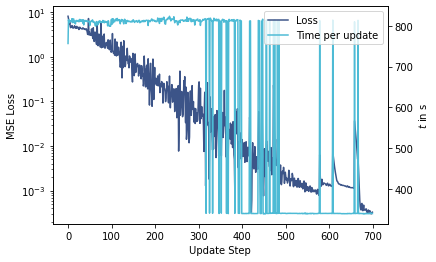

In [11]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Update Step')
ax1.set_ylabel('MSE Loss')
ax1.semilogy(loss_history, color='#3c5488ff', label='Loss')
ax2 = ax1.twinx()
ax2.plot(times_per_update, label='Time per update', color='#4dbbd5ff')
ax2.set_ylabel('$t$ in s')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.savefig('Train_history_diamond.png')
plt.show()


Next, we visualize convergence of our observables, the stress and stiffness tensor values.

Predicted stress tensor: [[-0.19772905 -0.1174123   0.1630551 ]
 [ 0.01021396 -0.18555078 -0.05879211]
 [ 0.01427229 -0.05110607  0.16001081]]


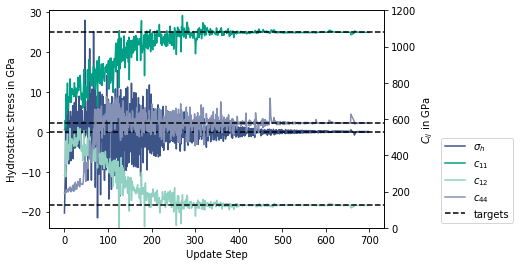

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('Update Step')
ax.set_ylabel('Hydrostatic stress in GPa')

if 'stress' in predicted_quantities[0]:
    pressure_series = [jnp.trace(prediction_dict['stress']) / convert_from_GPa_to_kJ_mol_nm_3 / 3. for
                       prediction_dict in predicted_quantities]
    ax.plot(pressure_series, label='$\sigma_h$', color='#3c5488ff')
    ax.axhline(y=0., linestyle='--', color='k')
    print('Predicted stress tensor:', predicted_quantities[-1]['stress'] / convert_from_GPa_to_kJ_mol_nm_3)

if 'stiffness' in predicted_quantities[0]:
    stiffness_list = [prediction_dict['stiffness'] for prediction_dict in predicted_quantities]
    stiffness_array = jnp.stack(stiffness_list) / convert_from_GPa_to_kJ_mol_nm_3  # back to GPa
    ax1 = ax.twinx()
    ax1.set_ylabel('$C_{ij}$ in GPa')
    ax1.set_ylim([0, 1200])
    ax1.plot(stiffness_array[:, 0], label='$c_{11}$', color='#00a087ff')
    ax1.plot(stiffness_array[:, 1], label='$c_{12}$', color='#91d1c2ff')
    ax1.axhline(y=c_12_target, linestyle='--', color='k')
    ax1.plot(stiffness_array[:, 2], label='$c_{44}$', color='#8491b4ff')
    ax1.axhline(y=c_44_target, linestyle='--', color='k')
    ax1.axhline(y=c_11_target, linestyle='--', label='targets', color='k')


fig.legend(loc="lower right", bbox_to_anchor=(1.4, 0.), bbox_transform=ax1.transAxes)
plt.savefig('Stress_stiffness_history.png')
plt.show()

## Validate simulation results

Given that we've trained the model on rather short trajectories, let's validate the model on a longer trajectory.
This allows to detect if the model overfitted to initial conditions or drifts away from the targets.

In [13]:
total_time_long = 11000.  # 11 ns
t_equilib_long = 1000.  # 1 ns
print_every = 0.1


long_trajectory_struct = custom_simulator.process_printouts(dt, total_time_long, t_equilib_long, print_every)
trajectory_generator = difftre.trajectory_generator_init(simulation_funs, long_trajectory_struct)
long_traj_state = trajectory_generator(final_energy_params, init_sim_state)
quantity_traj = difftre.compute_quantity_traj(long_traj_state, quantity_dict, neighbor_fn, final_energy_params)

stress_tensor = jnp.mean(quantity_traj['stress'], axis=0)
print('Predicted stress tensor:', stress_tensor / convert_from_GPa_to_kJ_mol_nm_3)

born_stress_prod_snapshots = sigma_tensor_prod(quantity_traj['born_stress'])
stress_product_born_mean = jnp.mean(born_stress_prod_snapshots, axis=0)
born_stress_tensor_mean = jnp.mean(quantity_traj['born_stress'], axis=0)
born_stiffness_mean = jnp.mean(quantity_traj['born_stiffness'], axis=0)
stiffness_tensor = stiffness_tensor_fn(born_stiffness_mean, born_stress_tensor_mean, stress_product_born_mean)

stiffness_components = custom_quantity.stiffness_tensor_components_cubic_crystal(stiffness_tensor)
print('Predicted c_11:', stiffness_components[0] / convert_from_GPa_to_kJ_mol_nm_3, 'GPa; Target:', c_11_target, 'GPa')
print('Predicted c_12:', stiffness_components[1] / convert_from_GPa_to_kJ_mol_nm_3, 'GPa; Target:', c_12_target, 'GPa')
print('Predicted c_44:', stiffness_components[2] / convert_from_GPa_to_kJ_mol_nm_3, 'GPa; Target:', c_44_target, 'GPa')


with open(long_traj_pickle_file_path, 'wb') as f:
    pickle.dump([stress_tensor, stiffness_components], f)

Predicted stress tensor: [[ 0.2783271   0.02886999 -0.01478336]
 [-0.00710172  0.29656953  0.00122136]
 [-0.00677423  0.02811435  0.3048873 ]]
Predicted c_11: 1069.523 GPa; Target: 1079.0 GPa
Predicted c_12: 114.45794 GPa; Target: 124.0 GPa
Predicted c_44: 559.6833 GPa; Target: 578.0 GPa


In [14]:
# you can skip the long run above and just load results
stress_tensor, stiffness_components = pickle.load(open(long_traj_pickle_file_path, "rb" ))

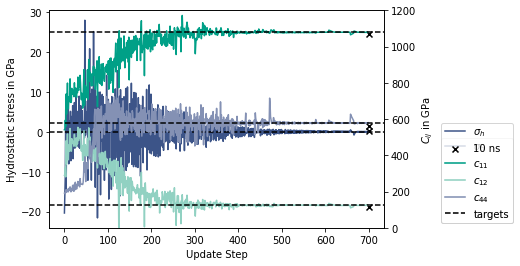

In [15]:
final_epoch = num_updates
x_position = [final_epoch for i in range(3)]
stiffnesses_GPa = stiffness_components / convert_from_GPa_to_kJ_mol_nm_3

ax.scatter(final_epoch, jnp.trace(stress_tensor) / convert_from_GPa_to_kJ_mol_nm_3 / 3., marker='x', 
           color='k', label='10 ns')
ax1.scatter(x_position, stiffnesses_GPa, marker='x', color='k')

fig.legend(loc="lower right", bbox_to_anchor=(1.4, 0.), bbox_transform=ax1.transAxes)
fig.savefig('Stress_stiffness_history.png')
fig